In [1]:
import numpy as np
import pandas as pd 


from numpy import array
import torch
from torch import cat, no_grad, manual_seed
import gc
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import Dataset,DataLoader

#Sklearn
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

manual_seed(444422)

In [2]:
df=pd.read_csv('../datos/AirPassengers.csv')
df['Month']=pd.to_datetime(df['Month'], infer_datetime_format=True)
df=df.set_index(['Month'])
df_log=np.log(df)
data_shift=df_log-df_log.shift()
data_shift = data_shift.dropna()
data_shift

,#Passengers
Month,
1949-02-01,0.052186
1949-03-01,0.112117
1949-04-01,-0.022990
1949-05-01,-0.064022
1949-06-01,0.109484
...,...
1960-08-01,-0.026060
1960-09-01,-0.176399
1960-10-01,-0.097083


In [3]:
p_train = 0.8

train_set = data_shift.iloc[:int(143*0.8)]
valid_set = data_shift.iloc[int(143*0.8):]

In [4]:
def split_sequence(sequence, n_steps):
    x, y = list(), list()
    for i in range(len(sequence)):
        
        end_ix = i + n_steps
        
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return array(x), array(y)

n_steps = 12
train_x,train_y = split_sequence(np.array(train_set['#Passengers']),n_steps)
valid_x,valid_y = split_sequence(np.array(valid_set['#Passengers']),n_steps)

In [5]:
#scaler = MinMaxScaler((0.3, np.pi-0.3))
#train_x = scaler.fit_transform(train_x)
#train_y = (-1.6/(np.min(train_y) - np.max(train_y)))*train_y - 0.8 + np.min(train_y)*(1.6/(np.min(train_y) - np.max(train_y)))

In [6]:
class ElecDataset(Dataset):
    def __init__(self,feature,target):
        self.feature = feature
        self.target = target
    
    def __len__(self):
        return len(self.feature)
    
    def __getitem__(self,idx):
        item = self.feature[idx]
        label = self.target[idx]
        
        return item,label

In [7]:
class CNN_ForecastNet(nn.Module):
    def __init__(self):
        super(CNN_ForecastNet,self).__init__()
        self.fc1 = nn.Linear(12,3)
        self.fc2 = nn.Linear(3,1)
        
    def forward(self,x):
        x = torch.flatten(x, 1)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        
        return x

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN_ForecastNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

In [31]:
total_params = sum(
	param.numel() for param in model.parameters()
)
total_params

43

In [32]:
train = ElecDataset(train_x.reshape(train_x.shape[0],train_x.shape[1],1),train_y)
valid = ElecDataset(valid_x.reshape(valid_x.shape[0],valid_x.shape[1],1),valid_y)
train_loader = torch.utils.data.DataLoader(train,batch_size=1,shuffle=False)
valid_loader = torch.utils.data.DataLoader(train,batch_size=1,shuffle=False)

In [33]:
train

In [34]:
train_losses = []
valid_losses = []
def Train():
    
    running_loss = .0
    
    model.train()
    
    for idx, (inputs,labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.float().to(device)
        optimizer.zero_grad()
        preds = model(inputs.float())
        preds = torch.reshape(preds, (-1,))
        loss = criterion(preds,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss
        
    train_loss = running_loss/len(train_loader)
    train_losses.append(train_loss.detach().numpy())
    
    print(f'train_loss {train_loss}')
    
def Valid():
    running_loss = .0
    
    model.eval()
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_loader):
            inputs = inputs.to(device)
            labels = labels.float().to(device)
            optimizer.zero_grad()
            preds = model(inputs.float())
            preds = torch.reshape(preds, (-1,))
            loss = criterion(preds,labels)
            running_loss += loss
            
        valid_loss = running_loss/len(valid_loader)
        valid_losses.append(valid_loss.detach().numpy())
        print(f'valid_loss {valid_loss}')
        return valid_loss

In [35]:
epochs = 200 # Se necesitan varias iteraciones
for epoch in range(epochs):
    print('epochs {}/{}'.format(epoch+1,epochs))
    Train()
    loss_valid = Valid()
        
    gc.collect()

epochs 1/200
train_loss 0.021586457267403603
valid_loss 0.020543430000543594
epochs 2/200
train_loss 0.019668063148856163
valid_loss 0.018757915124297142
epochs 3/200
train_loss 0.0180007703602314
valid_loss 0.017209380865097046
epochs 4/200
train_loss 0.016559084877371788
valid_loss 0.01587563194334507
epochs 5/200
train_loss 0.01532124262303114
valid_loss 0.014734883792698383
epochs 6/200
train_loss 0.01426576729863882
valid_loss 0.013765834271907806
epochs 7/200
train_loss 0.013371696695685387
valid_loss 0.012947854585945606
epochs 8/200
train_loss 0.012618916109204292
valid_loss 0.012261347845196724
epochs 9/200
train_loss 0.011988453567028046
valid_loss 0.011687975376844406
epochs 10/200
train_loss 0.011462700553238392
valid_loss 0.011210878379642963
epochs 11/200
train_loss 0.01102559082210064
valid_loss 0.010814790613949299
epochs 12/200
train_loss 0.010662714950740337
valid_loss 0.010486150160431862
epochs 13/200
train_loss 0.010361340828239918
valid_loss 0.010213067755103111
e

epochs 107/200
train_loss 0.003354668850079179
valid_loss 0.003327201120555401
epochs 108/200
train_loss 0.0033093998208642006
valid_loss 0.003282854100689292
epochs 109/200
train_loss 0.0032654874958097935
valid_loss 0.0032393725123256445
epochs 110/200
train_loss 0.0032224473543465137
valid_loss 0.0031967710237950087
epochs 111/200
train_loss 0.0031802919693291187
valid_loss 0.003155055921524763
epochs 112/200
train_loss 0.003139026230201125
valid_loss 0.0031142346560955048
epochs 113/200
train_loss 0.0030986552592366934
valid_loss 0.0030742965172976255
epochs 114/200
train_loss 0.00305915717035532
valid_loss 0.003035241737961769
epochs 115/200
train_loss 0.0030205559451133013
valid_loss 0.0029970856849104166
epochs 116/200
train_loss 0.0029828574042767286
valid_loss 0.002959832549095154
epochs 117/200
train_loss 0.0029460641089826822
valid_loss 0.002923480933532119
epochs 118/200
train_loss 0.0029101702384650707
valid_loss 0.0028880310710519552
epochs 119/200
train_loss 0.0028751804

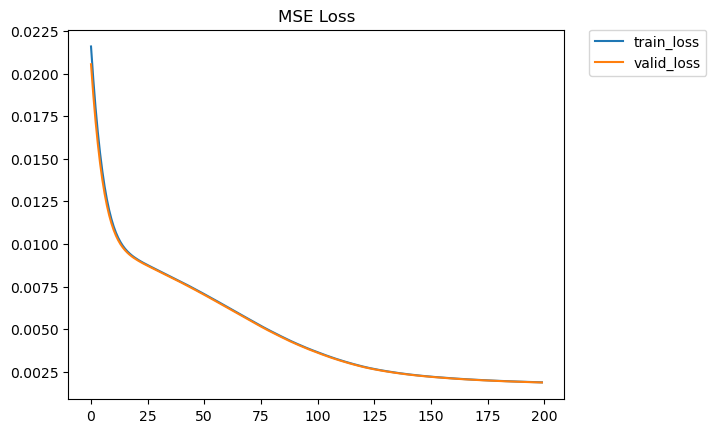

In [36]:
plt.plot(train_losses,label='train_loss')
plt.plot(valid_losses,label='valid_loss')
plt.title('MSE Loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [37]:
inputs = train_x.reshape(train_x.shape[0],train_x.shape[1],1)

len(inputs)

102

In [38]:
model.eval()

CNN_ForecastNet(
  (fc1): Linear(in_features=12, out_features=3, bias=True)
  (fc2): Linear(in_features=3, out_features=1, bias=True)
)

In [39]:
model.eval()
prediction = []
batch_size = 1
iterations =  int(inputs.shape[0]/batch_size)

for i in range(iterations):
    preds = model(torch.tensor(inputs[batch_size*i:batch_size*(i+1)]).float())
    prediction.append(preds[0].detach().numpy())
prediction = np.array(prediction)

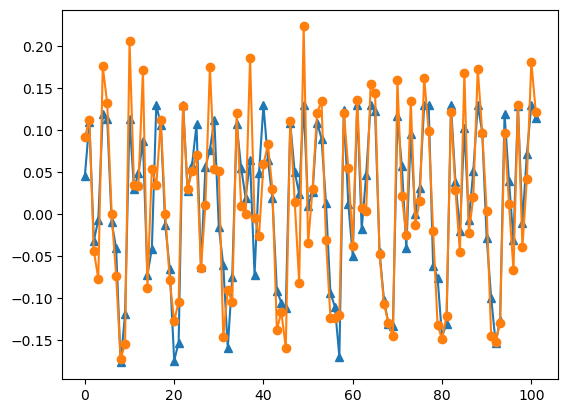

In [40]:
plt.plot(prediction, marker='^')
plt.plot(train_y, marker='o')
plt.show()

In [41]:
np.sum( (prediction - train_y)**2 )/len(train_y)

1.9834973051952893

In [42]:
inputs = valid_x.reshape(valid_x.shape[0],valid_x.shape[1],1)

len(inputs)

17

In [43]:
prediction = []
batch_size = 1
iterations =  int(inputs.shape[0]/batch_size)

for i in range(iterations):
    preds = model(torch.tensor(inputs[batch_size*i:batch_size*(i+1)]).float())
    prediction.append(preds[0].detach().numpy())
prediction = np.array(prediction)

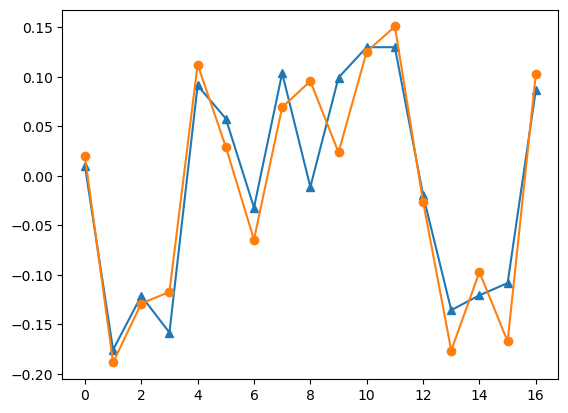

In [44]:
plt.plot(prediction, marker='^')
plt.plot(valid_y, marker='o')
plt.show()

In [45]:
error = 0

for i in range(len(prediction)):
    error = error + (prediction[i] - valid_y[i])**2
error/len(prediction)

array([0.00170867], dtype=float32)